# Homework 5
## Astro 530 - Stellar Atmospheres

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import constants as c
from astropy.modeling.models import BlackBody
from scipy.special import expn

from astro530 import NIntegrate

In [6]:
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

### 9. A Grey Atmosphere

(a) Show that for a grey atmosphere, the temperature profile is $$T(\tau) = T_\rm{eff} \left(\frac{3}{4}\left(\tau + \frac{2}{3}\right)\right)^{1/4}$$

(b) Write a function to find $\mathscr{F}_\nu(0)$ 
- From the temperature profile, get $S_\nu(\tau) = B_\nu\left(T = T_\rm{eff} \left(\frac{3}{4}\left(\tau + \frac{2}{3}\right)\right)^{1/4}\right)$
- Integrate over $S_\nu(\tau) E_2(\tau)\, d\tau$ for each $\tilde{\nu}$

In [7]:
def B_tau(tau, wv, Teff = 8700 * u.K):
    
    temp_grad = Teff * (3/4 * (tau + 2/3)) ** 0.25                # get temperature gradient
    B_nus = [BlackBody(T) for T in temp_grad]                     # define blackbody fns for each temp
    S_tau = u.Quantity([B_nu(wv) for B_nu in B_nus])              # calculate S(tau) at a specific wavenumber
    return S_tau

def F_nu(wv):
    H = np.zeros_like(wv.value) * u.erg / u.s / u.cm **2 / u.sr / u.Hz
    for i in range(len(wv)):
        def integrand(t): return 1/2 * B_tau(t, wv[i]) * expn(2, t)
        H[i] = NIntegrate(integrand, -18, 2, 25)                     # take integral over tau for each wavenumber
    flux = H * (4 * np.pi * u.sr)                                    # convert to flux
    return flux

In [8]:
wavenum = np.linspace(1e-16, 12, 100) * 1 / u.micron

F0 = F_nu(wavenum)

(c) From Eddington-Barbier, we expect: 
\begin{align*}
    H_\nu(0) &= \frac{1}{4} S_\nu(\tau =2/3)\\
                       &= \frac{1}{4} B_\nu\left(T(\tau = 2/3)\right)\\
                       &= \frac{B_\nu\left(T_\text{eff}\right)}{4}
\end{align*}

$$\implies \boxed{\mathscr{F}_\nu(0) = \pi B_\nu(T_\text{eff})}$$

In [9]:
def F0_EB(wv):
    bb_8700 = BlackBody(8700*u.K)
    I_nu = bb_8700(wv)
    F_nu = (np.pi * u.sr) * I_nu
    return F_nu

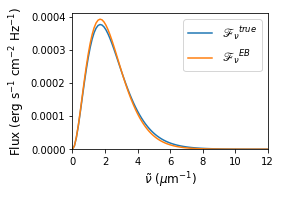

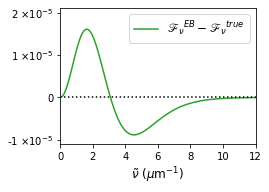

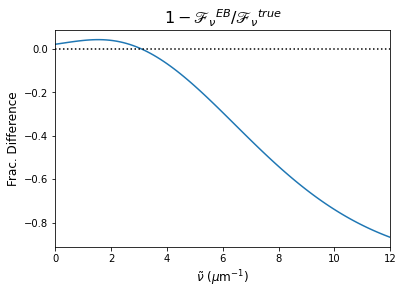

In [48]:
## (d) Plot F from calculation and from E-B approx.
plt.figure(figsize = (3.5, 2.5))
plt.plot(wavenum, F0, label = r'${\mathscr{F}_\nu}^{true}$')
plt.plot(wavenum, F0_EB(wavenum), label = r'${\mathscr{F}_\nu}^{EB}$')

plt.xlim(0, 12)
plt.ylim(0, 0.00041)

plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$)')
plt.xlabel(r'$\tilde{\nu}$ ($\mu$m$^{-1}$)')

plt.legend()

plt.savefig('hw5_d.1.png', bbox_inches = 'tight')
plt.show()

plt.figure(figsize = (3.5, 2.5))
plt.plot(wavenum, F0_EB(wavenum) - F0, color ='C2', label = r'${\mathscr{F}_\nu}^{EB} - {\mathscr{F}_\nu}^{true}$')
plt.hlines(0, 0, 12, 'k', ':')

plt.ylim(-1.1e-5, 2.1e-5)
plt.xlim(0, 12)

#plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$)')
plt.xlabel(r'$\tilde{\nu}$ ($\mu$m$^{-1}$)')

yticks = plt.yticks()[0][1:-1:]
yticklabels = ['{:g} '.format(ytick * 10 ** 5) + r'$\times 10^{-5}$' for ytick in yticks]
yticklabels[1] = '0'
plt.yticks(yticks, yticklabels)

plt.legend()

plt.savefig('hw5_d.2.png', bbox_inches = 'tight')
plt.show()

plt.plot(wavenum, (F0_EB(wavenum) - F0)/F0)
plt.hlines(0, 0, 12, 'k', ':')

plt.xlim(0, 12)

plt.title(r'$1 - {\mathscr{F}_\nu}^{EB}/{\mathscr{F}_\nu}^{true}$')
plt.ylabel(r'Frac. Difference')
plt.xlabel(r'$\tilde{\nu}$ ($\mu$m$^{-1}$)')

plt.savefig('hw5_d.3.png', bbox_inches = 'tight')
plt.show()

(d) The E-B approximation overestimates the emergent flux at lower wavenumbers and underestimates it at higher wavenumbers. The boundary between these two regimes is at about $\tilde{\nu} = 3.2\ \mu\text{m}^{-1} \approx \lambda = 315\ \text{nm}$, which is in the near UV.

In [15]:
### (e) Numerically calculate the second der. of the source function w.r.t. tau
def a2(tau):
    tau = np.array([tau - 0.1, tau, tau + 0.1])
    S = B_tau(tau, wavenum)

    dS = np.diff(S, axis = 0)
    dtau = np.diff(tau)
    first_der = np.array([dS[i]/dtau[i] for i in range(2)])
    tau1 = (tau[1:] + tau[:-1]) / 2
    second_der = np.diff(first_der, axis = 0) / np.diff(tau1)
    return second_der[0]

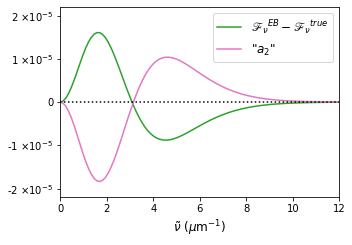

In [28]:
### Plot 'a_2' and difference between F_nu(true) and F_nu(E-B)
plt.figure(figsize=(5, 3.5))
plt.plot(wavenum, F0_EB(wavenum) - F0, color = 'C2', label = r'${\mathscr{F}_\nu}^{EB} - {\mathscr{F}_\nu}^{true}$')
plt.plot(wavenum, a2(1), color = 'C6', label = r'"$a_2$"')
plt.hlines(0, 0, 12, 'k', ':')

plt.xlabel(r'$\tilde{\nu}$ ($\mu$m$^{-1}$)')

yticks = plt.yticks()[0][1::2]
yticklabels = ['{:g} '.format(ytick * 10 ** 5) + r'$\times 10^{-5}$' for ytick in yticks]
yticklabels[2] = '0'
plt.yticks(yticks, labels = yticklabels)

plt.ylim(-2.2e-5, 2.2e-5)
plt.xlim(0, 12)

plt.legend()

plt.savefig('hw5_e.png', bbox_inches = 'tight')
plt.show()

(e) ${\mathscr{F}_\nu}^{\text{E-B}} - {\mathscr{F}_\nu}^{\text{true}} > 0$ where $a_2 < 0$ ($S_\nu$ is concave down). ${\mathscr{F}_\nu}^{\text{E-B}} - {\mathscr{F}_\nu}^{\text{true}} < 0$ where $a_2 > 0$ ($S_\nu$ is concave up). This is the behavior we expect based on the answers to the previous homeworks.

(f) The Planck function has two regimes. At **low frequencies**, it can be approximated by the [Rayleigh-Jeans law](https://en.wikipedia.org/wiki/Rayleigh%E2%80%93Jeans_law) $B_\nu = \frac{2 \nu^2 k_\rm{B} T}{c^2}$. This function is linear in $T$ so $B_\nu(\tau) \sim \tau^{1/4}$, which would be **concave down**. At **high frequencies**, the exponential term dominates and the Planck function approaches the [Wien Approximation](https://en.wikipedia.org/wiki/Wien_approximation), $B_\nu = \frac{2 h \nu^3}{c^2} e^{-h\nu\, /\,k_\rm{B} T}$. In the Wien approx. limit, $B_\nu(\tau) \sim e^{-\tau^{-1/4}}$, which is **concave up** for all $\tau$.

Basically, ~to the left of the peak of $B_\nu(T_\rm{eff})$, the source function is concave down and to the right of the peak, it is concave up. 

(g) It's not a blackbody but like, it's pretty close.